This is clustering analysis for tumour genomic variant data in Table S2B of Iorio et. al (http://www.cell.com/fulltext/S0092-8674(16)30746-2). The table lists >727 000 mutations, and includes 29 cancer types. Here's the header and start of the table:

<img src="IorioTableS2B_header.png">

Before we can apply any ML algorithm to this data, it has to be compressed in some meaningful form (position on DNA and the mutation type is far too many dimensional representation)

--> 96-dimensional representation with the frequencies of mutations in context of nearest-neighbour bases (5'to 3') in pyrimidine base (ie. only C > N and T > N substitutions. The two other cases, G > N and A > N, are taken to the reverse strand by taking a reverse complement of the sequence)

--> R code using biomaRt library that can be used for online mining of the the Ensembl database of Human genome indexed by a trancript id --> Get the nearest-neighbout context for each mutation in the table 

--> 96-dimensional vector of mutation frequencies for each unique sample name (donor identifier)

<img src="96d.png">

In [ ]:
Import packages:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

Import data and check that the dimensions are correct. Here 'data'is the matrix of samples-by-96 substitution classes, 'types'are the char strings for cancer types in the order of the samples, 'numtypes' are their numeric labels 1-27 in the order given by the dataframe 'possible_types'. 

In [6]:
data = open('csc.csv', 'rt')
data = np.loadtxt(data, delimiter=",")
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
print(data.shape)
types = pd.read_csv('types.csv',header=None)
print(types.shape)
numtypes = open('types_numeric.csv', 'rt')
numtypes = np.loadtxt(numtypes, delimiter=",")
print(numtypes.shape)
possible_types = pd.read_csv('possible_types.csv',header=None)
print(possible_types.shape)

(6754, 96)
(6754, 1)
(6754,)
(27, 1)


Let's first make a principal component analysis, PCA.
https://en.wikipedia.org/wiki/Principal_component_analysis

As a reminder of how NOT TO DO IT: PCA on substitution class vectors directly (or even on centered vectors) does not yield clusters and is dominated by outliers. 

explained_variance_ratio:
[ 0.09793888  0.05990145]


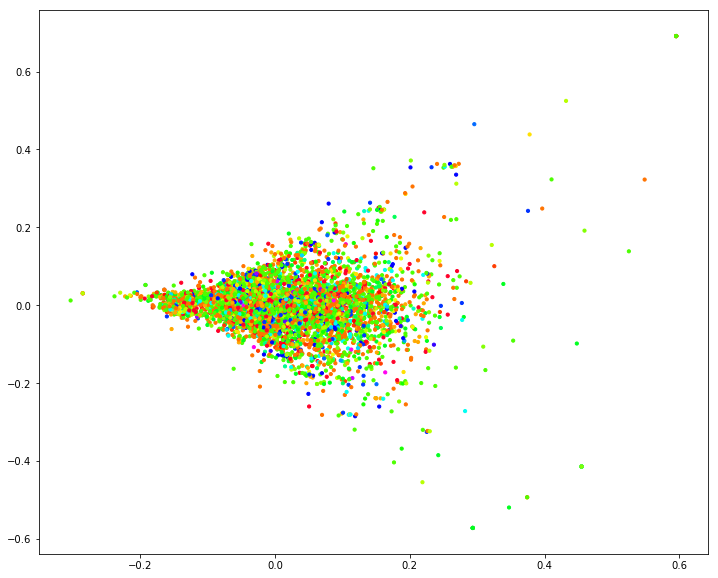

In [7]:
pca1 = decomposition.PCA(n_components=2)
pca1.fit(data)
X1 = pca1.transform(data)
print "explained_variance_ratio:"
print(pca1.explained_variance_ratio_) 
plt.rcParams['figure.figsize'] = (12,10)
normcolors = matplotlib.colors.Normalize(vmin=1.0, vmax=27.0)
plt.scatter(X1[:, 0], X1[:, 1], c=normcolors(numtypes),cmap=plt.cm.gist_rainbow, s=10)
plt.show()

Standard scaling to unit variance makes a difference

explained_variance_ratio:
[ 0.02425496  0.02137037]


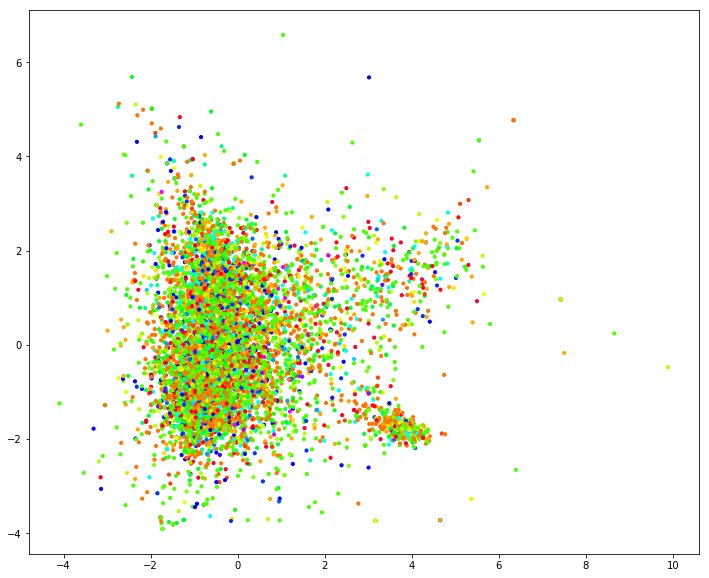

In [8]:
pca1s = decomposition.PCA(n_components=2);
pca1s.fit(scaled_data);
X1s = pca1s.transform(scaled_data);
print "explained_variance_ratio:"
print(pca1s.explained_variance_ratio_);
plt.rcParams['figure.figsize'] = (12,10);
normcolors = matplotlib.colors.Normalize(vmin=1.0, vmax=27.0)
plt.scatter(X1s[:, 0], X1s[:, 1], c=normcolors(numtypes), cmap=plt.cm.gist_rainbow, s=10);
plt.show();

Let's look at the cluster in the lower right corner more closely:

number of samples in this cluster:
307


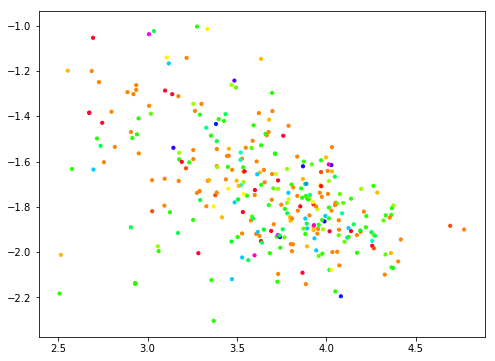

In [9]:
x=X1s[:,0];
y=X1s[:,1];
xind= np.where([(x >= 2.5) & (x < 5.0) ]);
xind=xind[1];
yind= np.where([(y > -2.5) & (y < -1.0)]);
yind=yind[1];
ind=np.array(list(set(xind).intersection(yind)));
print "number of samples in this cluster:"
print len(ind)
plt.rcParams['figure.figsize'] = (8,6)
normcolors = matplotlib.colors.Normalize(vmin=1.0, vmax=27.0)
plt.scatter(X1s[ind, 0], X1s[ind, 1], c=normcolors(numtypes[ind]), cmap=plt.cm.gist_rainbow, s=10);
plt.show();

The mean profile in this cluster resembles the mutational signature number 7 in Cosmic database: 
http://cancer.sanger.ac.uk/cosmic/signatures

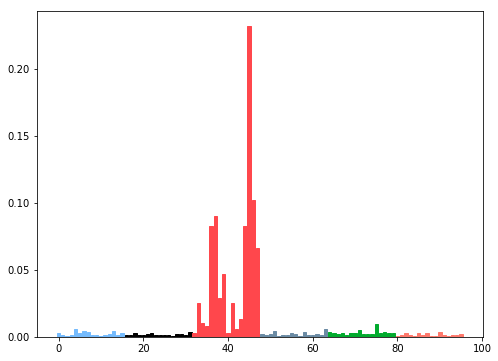

In [10]:
clusterprofile=sum(data[ind,:])/sum(sum(data[ind,:]))

barlist=plt.bar(np.arange(96), clusterprofile)
for i in range(0,16):
    barlist[i].set_color('xkcd:sky blue')
for i in range(16,32):
    barlist[i].set_color('k')    
for i in range(32,48):
    barlist[i].set_color('xkcd:light red')
for i in range(48,64):
    barlist[i].set_color('xkcd:gray blue')
for i in range(64,80):
    barlist[i].set_color('xkcd:kelly green')
for i in range(80,96):
    barlist[i].set_color('xkcd:salmon')    
plt.show()

Two cancer types are more abundant than the others in this cluster:

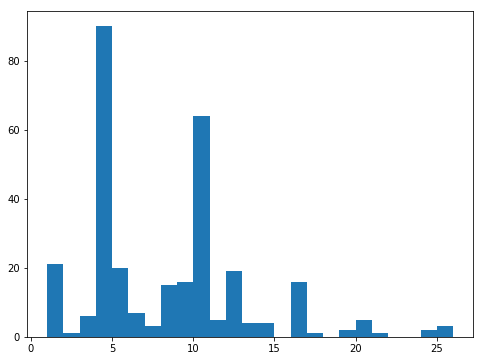

Two highest numbers in this cluster:
90
64


In [7]:
plt.hist(numtypes[ind], bins=np.arange(1,27,1));
plt.show()
print "Two highest numbers in this cluster:"
print sum(numtypes[ind]==4)
print sum(numtypes[ind]==10)

They are cancer types 4 and 10 (3 and 9 in python indexing), i.e. melanoma and colorectal cancers, exactly as described in the Cosmic db for signature 7. A coincidence? (YES! They are overrepresented in the data)

In [8]:
print possible_types.iloc[3];
print possible_types.iloc[9];

0    SKCM
Name: 3, dtype: object
0    COAD/READ
Name: 9, dtype: object


3rd component of pca does not reveal further clusters

explained_variance_ratio:
[ 0.02425622  0.02137962]


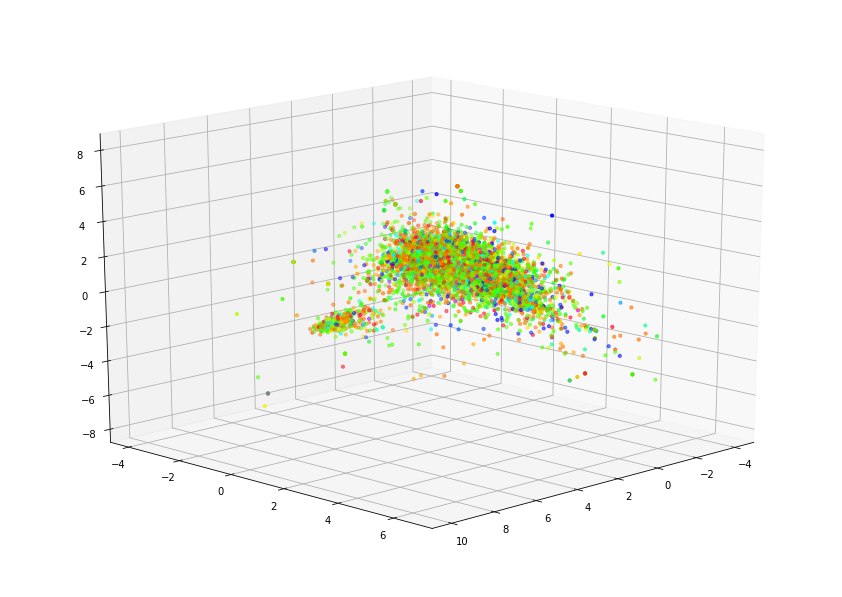

In [9]:
pca2 = decomposition.PCA(n_components=3);
pca2.fit(scaled_data);
X2 = pca2.transform(scaled_data);
print "explained_variance_ratio:"
print(pca1s.explained_variance_ratio_);
fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=18, azim=45)
plt.rcParams['figure.figsize'] = (10,7);
normcolors = matplotlib.colors.Normalize(vmin=1.0, vmax=27.0)
ax.scatter(X2[:, 0], X2[:, 1], X2[:, 2], c=normcolors(numtypes), cmap=plt.cm.gist_rainbow, s=10)
plt.show();

Let's try Multidimensional Scaling (Tries to preserve all distances)
https://en.wikipedia.org/wiki/Multidimensional_scaling

(6754, 6754)


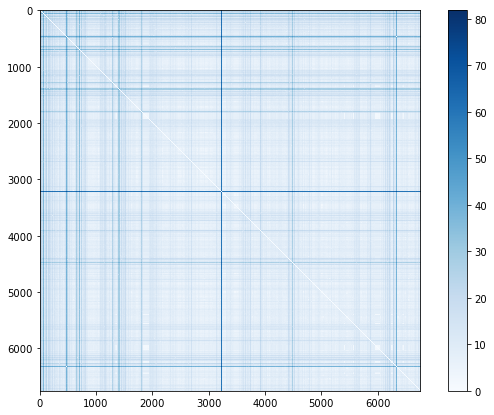

In [10]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(scaled_data)
print D.shape
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()

In [11]:
#from sklearn.manifold import MDS
#model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
#out = model.fit_transform(D)
#plt.scatter(out[:, 0], out[:, 1],  c=normcolors(numtypes), cmap=plt.cm.gist_rainbow, s=10)
#plt.axis('equal');

Takes too long. Try a local version (MLLE) with only 500 nearest-neighbour distances: 
https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Locally-linear_embedding

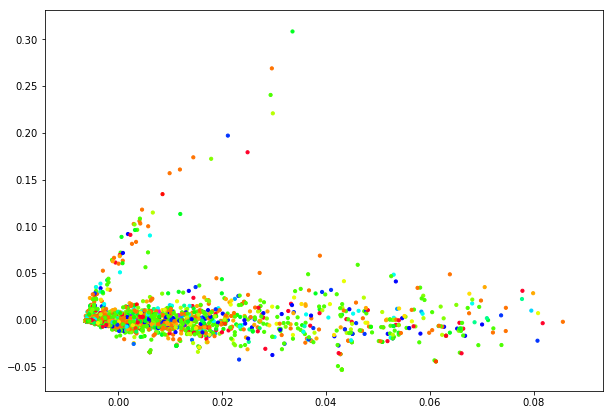

In [13]:
from sklearn.manifold import LocallyLinearEmbedding
LLE_model = LocallyLinearEmbedding(n_neighbors=500, n_components=2, method='modified')
out = LLE_model.fit_transform(scaled_data)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1],  c=normcolors(numtypes), cmap=plt.cm.gist_rainbow, s=10)
plt.show()

No new information, hmm...

Let's move on to a more modern technique, namely t-distributed stochastic neighbor embedding, or t-SNE for short.
https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [14]:
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn import datasets
from scipy.stats import gaussian_kde

In [15]:
tsne = TSNE(n_components=2, early_exaggeration = 24,verbose=1, perplexity=200, n_iter=1000, learning_rate=800 ,metric='correlation', init='pca');
tsne_results = tsne.fit_transform(scaled_data);

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6754
[t-SNE] Computed conditional probabilities for sample 2000 / 6754
[t-SNE] Computed conditional probabilities for sample 3000 / 6754
[t-SNE] Computed conditional probabilities for sample 4000 / 6754
[t-SNE] Computed conditional probabilities for sample 5000 / 6754
[t-SNE] Computed conditional probabilities for sample 6000 / 6754
[t-SNE] Computed conditional probabilities for sample 6754 / 6754
[t-SNE] Mean sigma: 0.286060
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.403024
[t-SNE] Error after 275 iterations: 0.403024


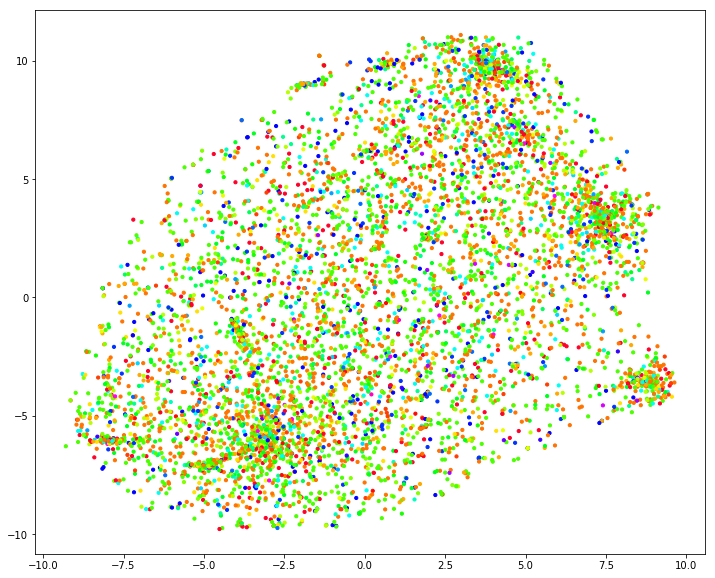

In [16]:
plt.rcParams['figure.figsize'] = (12,10);
plt.figure()
normcolors = matplotlib.colors.Normalize(vmin=1.0, vmax=27.0)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=normcolors(numtypes), cmap=plt.cm.gist_rainbow, s=10);
plt.show();

Recognize clusters by thinning the low density areas

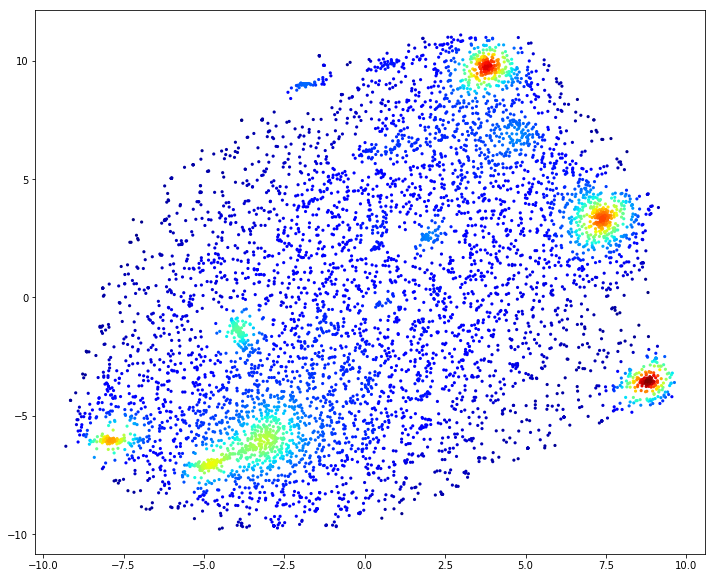

In [17]:
xy = np.vstack([tsne_results[:, 0], tsne_results[:, 1]])
z = gaussian_kde(xy, 0.1)(xy)
z=z/np.max(z)
plt.figure()
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=(z/max(z)), s=10, edgecolor='',cmap=plt.cm.jet)
plt.show()

In [18]:
print np.mean(z)
print np.sqrt(np.var(z))

0.268288519383
0.243202209071


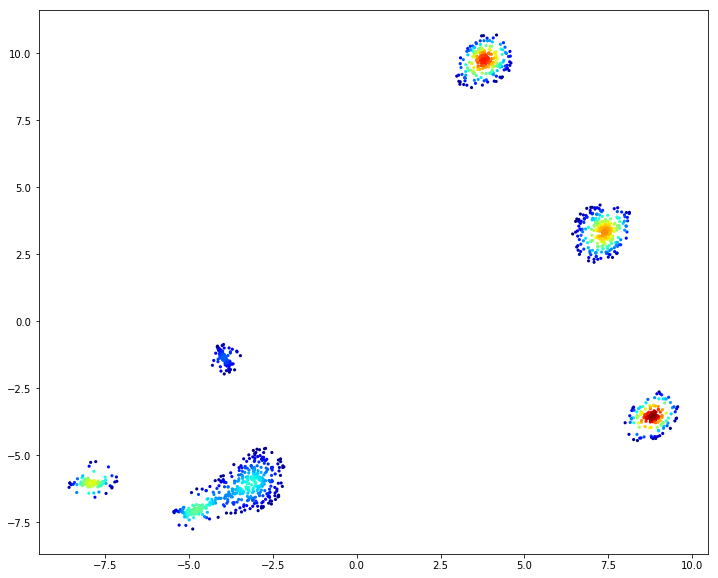

In [19]:
plt.figure()
indhigh = np.where(z>np.mean(z)+0.05)[0]
plt.scatter(tsne_results[indhigh, 0], tsne_results[indhigh, 1], c=z[indhigh], s=10, edgecolor='',cmap=plt.cm.jet)
plt.show()

Now we can apply the usual K-means algorithm to these clusters 
(https://en.wikipedia.org/wiki/K-means_clustering)

In [20]:
from sklearn.cluster import KMeans

In [21]:
Nclust=6
kmeans = KMeans(n_clusters=Nclust).fit(tsne_results[indhigh,:])    

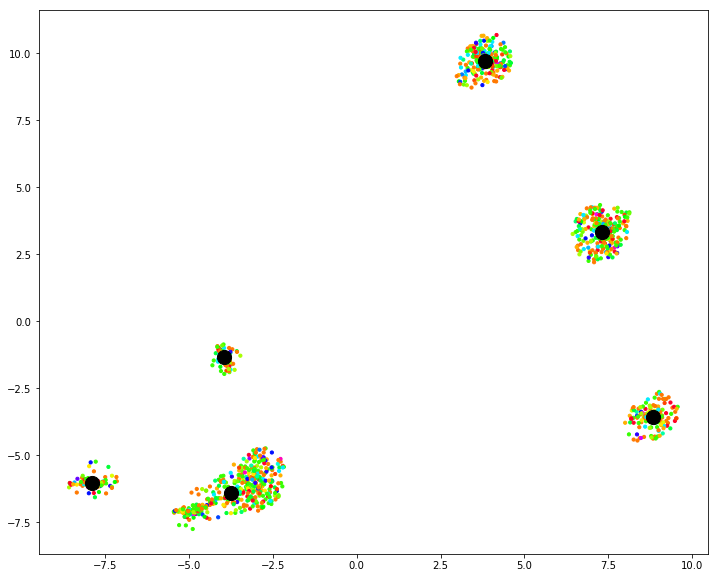

In [22]:
plt.figure()
normcolors = matplotlib.colors.Normalize(vmin=1.0, vmax=27.0)
plt.scatter(tsne_results[indhigh, 0], tsne_results[indhigh, 1], c=normcolors(numtypes[indhigh]), cmap=plt.cm.gist_rainbow, s=10);
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s=200, c='k', marker=(5, 3))
plt.show();

Next, make a dictionary which contains the indices of samples in each cluster, respectively.

In [23]:
clusterInd=dict()

for n in range(0,Nclust):
    clusterInd[n] = indhigh[np.where(kmeans.labels_== n)]


Now it's easy to plot the individual clusters,

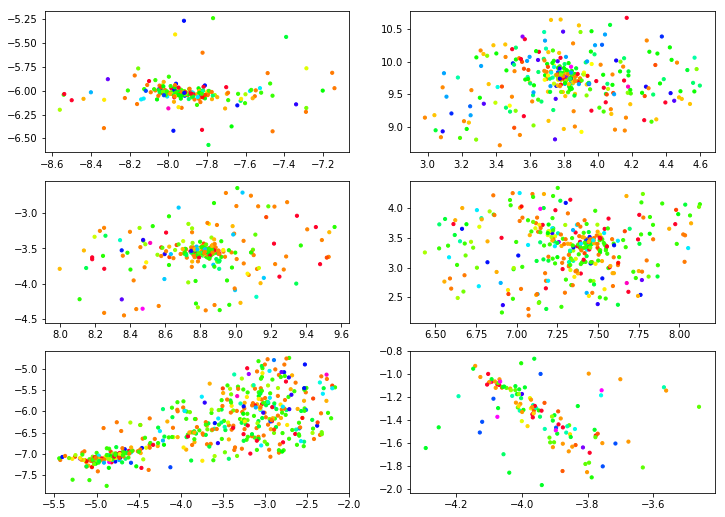

In [24]:
x = tsne_results[:,0]
y = tsne_results[:,1]

normcolors = matplotlib.colors.Normalize(vmin=1.0, vmax=27.0)
plt.figure(figsize=(12, 12))

for n in range(0,Nclust):
    plt.subplot(421+n)
    plt.scatter(x[clusterInd[n]], y[clusterInd[n]], c=normcolors(numtypes[clusterInd[n]]), cmap=plt.cm.gist_rainbow, s=10);


plt.show();

... and the mean substitution class profiles in each of them:

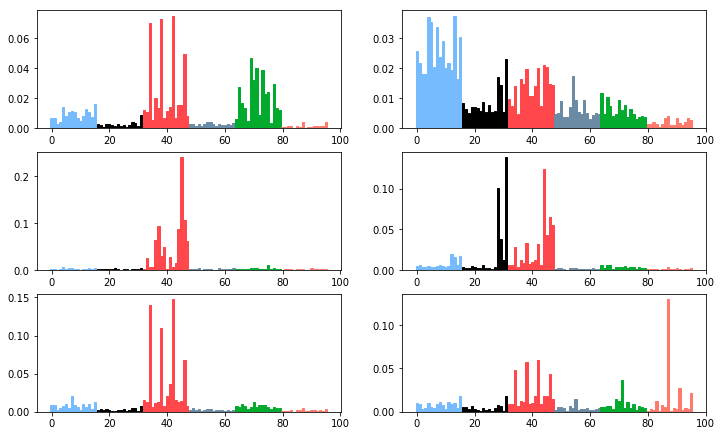

In [25]:
plt.figure()

for n in range(0,Nclust):
    plt.subplot(421+n)
    barlist=plt.bar(np.arange(96), sum(data[clusterInd[n],:])/sum(sum(data[clusterInd[n],:])))
    for i in range(0,16):
        barlist[i].set_color('xkcd:sky blue')
    for i in range(16,32):
        barlist[i].set_color('k')    
    for i in range(32,48):
        barlist[i].set_color('xkcd:light red')
    for i in range(48,64):
        barlist[i].set_color('xkcd:gray blue')
    for i in range(64,80):
        barlist[i].set_color('xkcd:kelly green')
    for i in range(80,96):
        barlist[i].set_color('xkcd:salmon')    
plt.show()

Histograms of cancer types in each cluster:

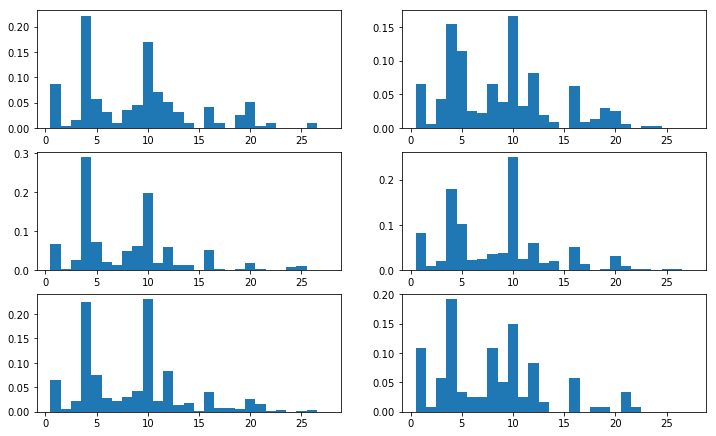

In [26]:
plt.figure()

for n in range(0,Nclust):
    plt.subplot(421+n)
    plt.hist(numtypes[clusterInd[n]], bins=np.arange(0.5,28.5,1), normed=True);

plt.show()

Next, we want to know which of the known COSMIC signatures are active in each of those clusters, or alternatively, inspect the signatures active in each sample, and subsequently perform clustering analysis to those. We will first take the latter approach. For this, we used the Expectation-Maximization algorithm to infer mutational signatures (eMU) by Fischer et al. which is a way to find a weight of each signature in a 96-dimensional profile. 

We have applied two versions of the eMU algorithm: the first one (activities_all) allows for any number of active signatures, whereas the second (activities_reg) tries to find a matching activity profile with at most 5 nonzero signature weights. 

In [27]:
activities_all = pd.read_csv('target_30_activities_tumours_allChannels.txt',header=None ,delim_whitespace=True)
activities_all = pd.DataFrame.as_matrix(activities_all)
activities_reg1 = pd.DataFrame.as_matrix(pd.read_csv('target_30_activities_tum_reg1.txt',header=None ,delim_whitespace=True))
activities_reg2 = pd.DataFrame.as_matrix(pd.read_csv('target_30_activities_tum_reg2.txt',header=None ,delim_whitespace=True))
activities_reg3 = pd.DataFrame.as_matrix(pd.read_csv('target_30_activities_tum_reg3.txt',header=None ,delim_whitespace=True))
activities_reg4 = pd.DataFrame.as_matrix(pd.read_csv('target_30_activities_tum_reg4.txt',header=None ,delim_whitespace=True))
activities_reg = np.vstack((np.vstack((np.vstack((activities_reg1,activities_reg2)),activities_reg3)),activities_reg4))
print(activities_all.shape)
print(activities_reg.shape)

(6754, 30)
(6750, 30)


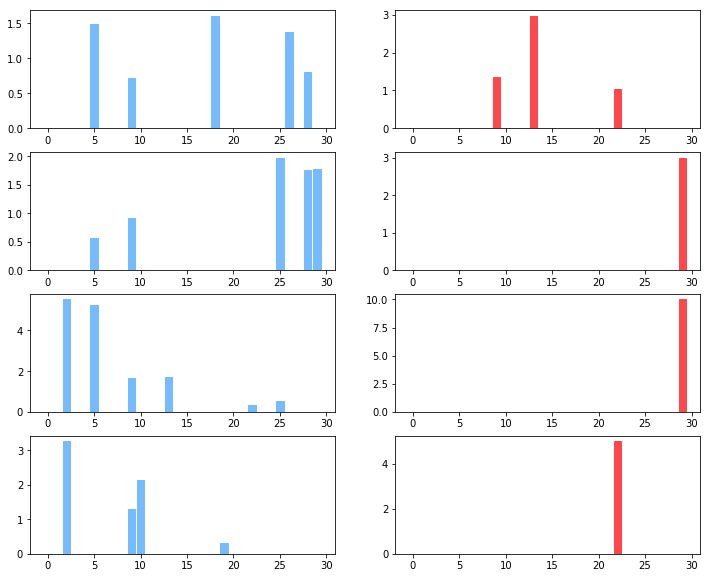

In [28]:
plt.rcParams['figure.figsize'] = (12,10);
plt.figure()

for n in np.array([0,1,2,3]):
    
    plt.subplot(421+2*n)
    barlist=plt.bar(np.arange(30), activities_all[0+n,:])
    for i in range(0,30):
        barlist[i].set_color('xkcd:sky blue')
     
    plt.subplot(421+2*n+1)
    barlist=plt.bar(np.arange(30), activities_reg[0+n,:])
    for i in range(0,30):
        barlist[i].set_color('xkcd:light red')
    
plt.show()

The difference in the plots above already tells that something is wrong...

Let's proceed and normalize the activity profiles for clustering:

In [29]:
irs_all = np.diag(1/np.sum(activities_all, axis=1))
irs_reg = np.diag(1/np.sum(activities_reg, axis=1))
print(irs_all.shape)
act_all_norm = np.dot(irs_all,activities_all)
act_reg_norm = np.dot(irs_reg,activities_reg)
print(act_all_norm.shape)
print(act_reg_norm.shape)
scale_all = StandardScaler()
scale_reg = StandardScaler()
act_all_scaled = scale_all.fit_transform(act_all_norm)
act_reg_scaled = scale_reg.fit_transform(act_reg_norm)

(6754, 6754)
(6754, 30)
(6750, 30)


In [ ]:
t-SNE for both versions:

In [30]:
tsne_act_all = TSNE(n_components=2, early_exaggeration =24,verbose=1, perplexity=200, n_iter=1000, learning_rate=500 ,metric='correlation', init='pca');
tsne_act_all_results = tsne_act_all.fit_transform(act_all_scaled);

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6754
[t-SNE] Computed conditional probabilities for sample 2000 / 6754
[t-SNE] Computed conditional probabilities for sample 3000 / 6754
[t-SNE] Computed conditional probabilities for sample 4000 / 6754
[t-SNE] Computed conditional probabilities for sample 5000 / 6754
[t-SNE] Computed conditional probabilities for sample 6000 / 6754
[t-SNE] Computed conditional probabilities for sample 6754 / 6754
[t-SNE] Mean sigma: 0.289754
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.504348
[t-SNE] Error after 350 iterations: 0.504348


In [31]:
tsne_act_reg = TSNE(n_components=2, early_exaggeration = 24,verbose=1, perplexity=200, n_iter=1000, learning_rate=800 ,metric='correlation', init='pca');
tsne_act_reg_results = tsne_act_reg.fit_transform(act_reg_scaled);

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6750
[t-SNE] Computed conditional probabilities for sample 2000 / 6750
[t-SNE] Computed conditional probabilities for sample 3000 / 6750
[t-SNE] Computed conditional probabilities for sample 4000 / 6750
[t-SNE] Computed conditional probabilities for sample 5000 / 6750
[t-SNE] Computed conditional probabilities for sample 6000 / 6750
[t-SNE] Computed conditional probabilities for sample 6750 / 6750
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.262474
[t-SNE] Error after 275 iterations: 0.262474


The results from the unrestricted version look alright, something we could analyze for clusters:

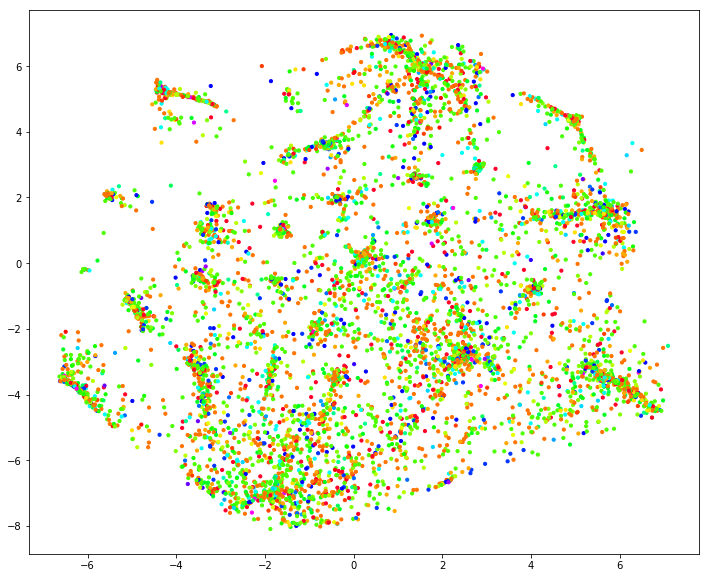

In [32]:
plt.rcParams['figure.figsize'] = (12,10);
plt.figure()
normcolors = matplotlib.colors.Normalize(vmin=1, vmax=32.0)

plt.scatter(tsne_act_all_results[:, 0], tsne_act_all_results[:, 1],  c=normcolors(numtypes), cmap=plt.cm.gist_rainbow, s=10);
plt.show();

Whereas the resctricted version produces something really weird:

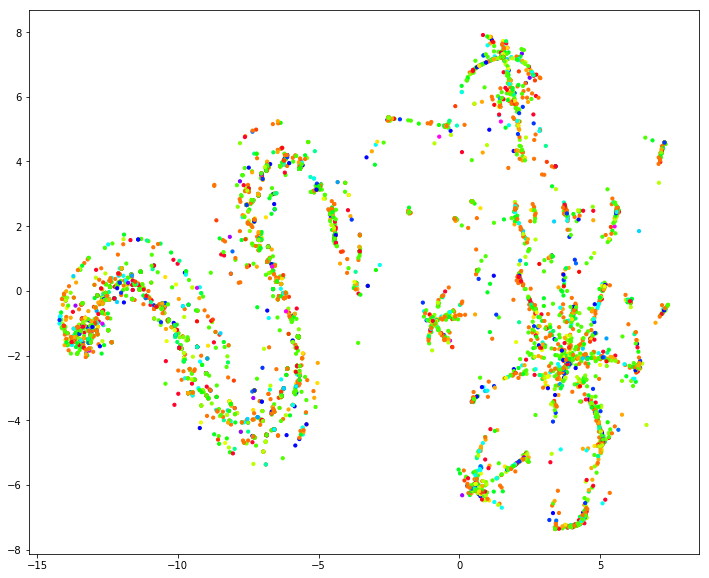

In [33]:
rs = np.sum(activities_reg, axis=1)
rsnorm = rs/np.max(rs)
plt.rcParams['figure.figsize'] = (12,10);
plt.figure()
normcolors = matplotlib.colors.Normalize(vmin=1, vmax=32.0)
plt.scatter(tsne_act_reg_results[:, 0], tsne_act_reg_results[:, 1],  c=normcolors(numtypes[0:6750]), cmap=plt.cm.gist_rainbow, s=10);
plt.show();

The reason for the difference is that the tumour-sample data is sparse: many samples contain only a few mutations, and eMU and its restricted version do not cope well with such data. Luckily, data from lab-cultured cell lines is different, with a large number of mutations in each line. This is the kind of data we will use because drug responses are measured for cell lines.